In [1]:
import numpy as np
import pandas as pd

import sys
import cv2
#from skimage.io import imread, imread_collection
from scipy import signal
import scipy.misc
from scipy.misc import imread
from scipy.ndimage import filters,distance_transform_edt
from matplotlib import pyplot as plt

import os
from os import listdir

from keras.models import Model
from keras import optimizers
from keras.layers import Input,Activation,Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization,Dropout

Using TensorFlow backend.


In [15]:
dir_path='/home/zoro/Desktop/nmumg_data'
main_path=dir_path+'/train_test_data'
path_train_input =main_path+'/train/Img'
path_test_input=main_path+'/test/Img'
path_train_gt = main_path+'/train/Bwdist'
path_test_gt=main_path+'/test/Bwdist'


path_predict=dir_path+'/predict'
path_output=dir_path+'/output'
path_frcnn_predict=dir_path+'/frcnn_predict'

nb_epoch =300
batch_size = 10
weight_file='nmumg_reg_ep300.hdf5'

In [4]:
#As this is a regression problem, train_label should be also normalized.
def prep_data(path_img,path_gt):
    data = []
    label = []

    img_list = sorted(listdir(path_img))
    gt_list=sorted(listdir(path_gt))
    i=0
    while (i<len(img_list)):
        img = np.array(imread(path_img +'/'+ img_list[i]),dtype=np.float64)
        #img = np.array(imread(path_img +'/'+ img_list[i]))
        #print img.shape
        img=(img-np.amin(img))*1.0/(np.amax(img)-np.amin(img))#img*1.0 transform array to double
        img=img*1.0/np.median(img)
        img_h=img.shape[0]        
        img_w=img.shape[1]        
        img=np.reshape(img,(img_h,img_w,1))         
        data.append(img)  
        
        gt =np.array(imread(path_gt + '/'+ gt_list[i]))
#---------------with or without normalization-----------------------        
        if np.count_nonzero(gt)!=0:
            nonzero_gt=gt[gt>0]
            gt=gt*1.0/np.median(nonzero_gt)

        gt=np.reshape(gt,(img_h,img_w,1))
        label.append(gt)
        
        i+=1
    data=np.array(data)
    label=np.array(label) 
    print data.shape, label.shape
    return data, label     

In [5]:
def prep_prediction_data(path_img):
    data = []
    img_list = sorted(listdir(path_img))
    i=0
    while (i<len(img_list)):
        img = np.array(imread(path_img +'/'+ img_list[i]),dtype=np.float64)
        img=(img-np.amin(img))*1.0/(np.amax(img)-np.amin(img))#img*1.0 transform array to double
        img=img*1.0/np.median(img)
        img_h=img.shape[0]        
        img_w=img.shape[1]
        img=np.reshape(img,(img_h,img_w,1))
        data.append(img)
        i+=1
    data=np.array(data)
    return data

In [7]:
def conv_block(input_tensor, kernel, filters):
    x=Conv2D(filters, (kernel, kernel), padding='same')(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    return x

In [8]:
kernel = 3
#------------encoder layers--------------------------------
inputs = Input((None,None, 1))
conv1=conv_block(inputs,kernel,filters=64)
conv1=conv_block(conv1,kernel,filters=64)
pool1=MaxPooling2D()(conv1)
    
conv2=conv_block(pool1,kernel,filters=128)
conv2=conv_block(conv2,kernel,filters=128)
pool2=MaxPooling2D()(conv2)

conv3=conv_block(pool2,kernel,filters=256)
conv3=conv_block(conv3,kernel,filters=256)
conv3=conv_block(conv3,kernel,filters=256)
pool3=MaxPooling2D()(conv3)

conv4=conv_block(pool3,kernel,filters=512)
conv4=conv_block(conv4,kernel,filters=512)
conv4=conv_block(conv4,kernel,filters=512)
pool4=MaxPooling2D()(conv4)
 
conv5=conv_block(pool4,kernel,filters=512)
conv5=conv_block(conv5,kernel,filters=512)
conv5=conv_block(conv5,kernel,filters=512)
pool5=MaxPooling2D()(conv5)


#--------------------decoder layers--------------------------

up6=UpSampling2D()(pool5)
conv6=conv_block(up6,kernel,filters=512)
conv6=conv_block(conv6,kernel,filters=512)
conv6=conv_block(conv6,kernel,filters=512)

up7=UpSampling2D()(conv6)
conv7=conv_block(up7,kernel,filters=512)
conv7=conv_block(conv7,kernel,filters=512)
conv7=conv_block(conv7,kernel,filters=512)
    
up8=UpSampling2D()(conv7)
conv8=conv_block(up8,kernel,filters=256)
conv8=conv_block(conv8,kernel,filters=256)
conv8=conv_block(conv8,kernel,filters=256)

up9=UpSampling2D()(conv8)
conv9=conv_block(up9,kernel,filters=128)
conv9=conv_block(conv9,kernel,filters=128)

up10=UpSampling2D()(conv9)
conv10=conv_block(up10,kernel,filters=64)

conv11=conv_block(conv10,kernel=1,filters=1)    
outputs=Activation('relu')(conv11)

autoencoder=Model(inputs=[inputs], outputs=[outputs])

#autoencoder.summary()

autoencoder.compile(loss="mean_squared_error", optimizer='adam', metrics=['mae','acc'])
print ('Compiled: OK')

Compiled: OK


In [9]:
train_data, train_label = prep_data(path_train_input,path_train_gt)

(95, 256, 256, 1) (95, 256, 256, 1)


In [ ]:
#---------------------train-------------------------
history=autoencoder.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch, verbose=1)
autoencoder.save_weights(weight_file)

Epoch 1/1


<type 'numpy.ndarray'>
(1, 640, 640, 1)
(640, 640)


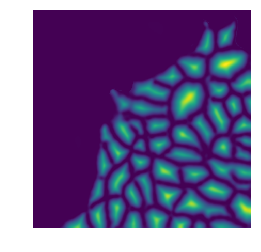

In [16]:
#-------------------predict----------------------------
autoencoder.load_weights(weight_file)
predict_data=prep_prediction_data(path_predict)
output = autoencoder.predict(predict_data, verbose=0)
print(type(output))
print(output.shape)

#output_label=np.argmax(output[0],axis=-1)
im=output[0][:,:,0]   
np.save(path_output+'/reg_out.npy',im)
data=np.load(path_output+'/reg_out.npy')
print(im.shape)

#save image to 8 bit
scipy.misc.imsave(path_output+'/reg_out_8bit.png',im)
#save image to the exat value

img=scipy.misc.toimage(im,high=np.max(im),low=np.min(im),mode='F')
img.save(path_output+'/reg_out_exact.tif')
img.save(path_frcnn_predict+'/reg_out_exact.tif')
plt.imshow(im)
plt.axis('off')
plt.savefig(path_output+'/reg_out_300dpi.tif',bbox_inches='tight',format='tif',dpi=300)
plt.show()